# LoanShark - Prediction of LeandingClub Loan Defaulters

## About LendingClub
LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform. The company claims that $15.98 billion in loans had been originated through its platform up to December 31, 2015.

LendingClub enables borrowers to create unsecured personal loans between $1,000 and $40,000. The standard loan period is three years. Investors can search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. LendingClub makes money by charging borrowers an origination fee and investors a service fee.

## About the Dataset
These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables. A data dictionary is provided in a separate file.


## Purpose of this analysis
Our goal is to build a machine learning model that can learn from the characteristics of each borrower who is known, so that we can predict a borrower whether it is fit for being invested and help the investment to make a wise decision.

## Contents

0 - Module imports and Reading data into the notebook  
1 - Data Cleaning  
2 - Distribution of The Loan Status Values  
3 - One Hot Encoding  
4 - Model Selection  
5 - Conclusion  

## 0 - Module imports and Reading data into the notebook

### a) Module imports

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import scipy
from pandas.api.types import is_string_dtype,is_numeric_dtype
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
from fancyimpute import KNN

# visualization
from matplotlib import pyplot as plt #or import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.svm import SVC
from sklearn import preprocessing
import fancyimpute
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score



from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib

%matplotlib inline

Using TensorFlow backend.
/Users/lunahuang/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## b) Reading data into the notebook

In [2]:
# Define a variable that points to the folder where data is stored
path = '/Users/lunahuang/Desktop/Machine_Learning/Loan_Shark/Data'

In [3]:
ori_loan_df = pd.read_csv(f'{path}/loan.csv')
print(ori_loan_df.shape)
ori_loan_df.head()

/Users/lunahuang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260668, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Print out list of columns
ori_loan_df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

### c) Train-Valid-Test split

In [ ]:
'''
(1) the training set:   70% of the data rows
(2) the validation set: 15% of the data rows
(3) the test set:       15% of the data rows'''

#define a dataframe splitter function here for this.
def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]

In [ ]:
#Calculate 30% of 2260668 rows

val_test_rows = (2260668*30)/100
print(val_test_rows)

## 1 - Data Cleaning

1) Delete the columns with more than 20% null data  
2) Manually delete some unnecessary columns  
3) Remove the features with very high correlation coefficients  
4) Dataset imputation with k-NN

### 1) Delete the columns with more than 20% null data  

In [5]:
#Find the count and percentage of values that are missing in the datafram
null_loan_df = pd.DataFrame({'Count':ori_loan_df.isnull().sum(),
                             'Percent':100*ori_loan_df.isnull().sum()/len(ori_loan_df)})

#print columns without null count
null_loan_df[null_loan_df['Count']==0]

,Count,Percent
loan_amnt,0,0.0
funded_amnt,0,0.0
funded_amnt_inv,0,0.0
term,0,0.0
int_rate,0,0.0
installment,0,0.0
grade,0,0.0
sub_grade,0,0.0
home_ownership,0,0.0
verification_status,0,0.0


In [6]:
#print columns with more than 0 null count
null_loan_df[null_loan_df['Count']>0]

,Count,Percent
id,2260668,100.000000
member_id,2260668,100.000000
emp_title,166969,7.385826
emp_length,146907,6.498389
annual_inc,4,0.000177
url,2260668,100.000000
desc,2134601,94.423462
title,23325,1.031775
zip_code,1,0.000044
dti,1711,0.075686


In [7]:
#print columns with more than 80% null data
a = null_loan_df[null_loan_df['Percent']>=80]

#print columns with more than 60% null data
b = null_loan_df[null_loan_df['Percent']>=60]

#print columns with more than 40% null data
c = null_loan_df[null_loan_df['Percent']>=40]

#print columns with more than 20% null data
d = null_loan_df[null_loan_df['Percent']>=20]

print("Numbers of columns with more than 80% null data: ", a.count())
print("Numbers of columns with more than 60% null data: ", b.count())
print("Numbers of columns with more than 40% null data: ", c.count())
print("Numbers of columns with more than 20% null data: ", d.count())

Numbers of columns with more than 80% null data:  Count      39
Percent    39
dtype: int64
Numbers of columns with more than 60% null data:  Count      42
Percent    42
dtype: int64
Numbers of columns with more than 40% null data:  Count      46
Percent    46
dtype: int64
Numbers of columns with more than 20% null data:  Count      58
Percent    58
dtype: int64


In [8]:
'''Due to no matther what percentage of null data it has, the rows are almost the same. 
Therefore, I choose delete the columns with more than 20% null data'''

#Delete the columns with more than 20% null data
clean_loan_df = ori_loan_df.dropna(axis=1, thresh=int(0.80*len(ori_loan_df)))
clean_loan_df.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N
5,5550,5550,5550.0,36 months,15.02,192.45,C,C3,Director COE,10+ years,...,60.0,0.0,0.0,831687.0,185378.0,65900.0,203159.0,N,Cash,N
6,2000,2000,2000.0,36 months,17.97,72.28,D,D1,Account Manager,4 years,...,NaN,0.0,0.0,854.0,854.0,0.0,0.0,N,Cash,N
7,6000,6000,6000.0,36 months,13.56,203.79,C,C1,Assistant Director,10+ years,...,85.7,0.0,0.0,117242.0,91535.0,33100.0,61742.0,N,DirectPay,N
8,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Legal Assistant III,10+ years,...,60.0,0.0,0.0,57426.0,41882.0,21500.0,34626.0,N,Cash,N
9,6000,6000,6000.0,36 months,14.47,206.44,C,C2,NaN,< 1 year,...,26.3,0.0,0.0,477390.0,105911.0,98300.0,89600.0,N,Cash,N


### 2) Manually delete some unnecessary columns  

In [9]:
'''Print the name of columns and choose the some necessary features'''
clean_loan_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct

In [10]:
filter_loan_df = clean_loan_df.filter(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 
                                       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 
                                       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 
                                       'title', 'dti', 'delinq_2yrs','inq_last_6mths', 'open_acc', 'pub_rec', 
                                       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 
                                       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
                                       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                                       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
                                       'last_credit_pull_d', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 
                                       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                                       'chargeoff_within_12_mths', 'delinq_amnt', 'pct_tl_nvr_dlq',
                                       'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bal_ex_mort' ,
                                       'debt_settlement_flag'])
                             
filter_loan_df.dtypes

loan_amnt                     int64
funded_amnt                   int64
funded_amnt_inv             float64
term                         object
int_rate                    float64
installment                 float64
grade                        object
emp_length                   object
home_ownership               object
annual_inc                  float64
verification_status          object
issue_d                      object
loan_status                  object
pymnt_plan                   object
purpose                      object
title                        object
dti                         float64
delinq_2yrs                 float64
inq_last_6mths              float64
open_acc                    float64
pub_rec                     float64
revol_bal                     int64
revol_util                  float64
total_acc                   float64
initial_list_status          object
out_prncp                   float64
out_prncp_inv               float64
total_pymnt                 

### 3) Remove the features with very high correlation coefficients

In [11]:
filter_loan_df_2 = filter_loan_df.copy()

# Convert the value of feature "term" from object to numeric
term_dict = {" 36 months": 36, " 60 months": 60}
filter_loan_df_2["term"] = filter_loan_df_2["term"].map(term_dict)
filter_loan_df_2["term"] = filter_loan_df_2["term"].astype("float")

filter_loan_df_2.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,debt_settlement_flag
0,2500,2500,2500.0,36.0,13.56,84.92,C,10+ years,RENT,55000.0,...,1878.0,34360.0,5.9,0.0,0.0,100.0,1.0,60124.0,16901.0,N
1,30000,30000,30000.0,60.0,18.94,777.23,D,10+ years,MORTGAGE,90000.0,...,24763.0,13761.0,8.3,0.0,0.0,95.0,1.0,372872.0,99468.0,N
2,5000,5000,5000.0,36.0,17.97,180.69,D,6 years,MORTGAGE,59280.0,...,18383.0,13800.0,0.0,0.0,0.0,100.0,0.0,136927.0,11749.0,N
3,4000,4000,4000.0,36.0,18.94,146.51,D,10+ years,MORTGAGE,92000.0,...,30505.0,1239.0,75.2,0.0,0.0,100.0,0.0,385183.0,36151.0,N
4,30000,30000,30000.0,60.0,16.14,731.78,C,10+ years,MORTGAGE,57250.0,...,9667.0,8471.0,8.9,0.0,0.0,92.3,0.0,157548.0,29674.0,N


In [12]:
# details of feature "emp_length"
filter_loan_df_2['emp_length'].unique()

array(['10+ years', '6 years', '4 years', '< 1 year', '2 years',
       '9 years', nan, '5 years', '3 years', '7 years', '1 year',
       '8 years'], dtype=object)

In [13]:
filter_loan_df_3 = filter_loan_df_2.copy()

# Convert the value of feature "emp_length" from object to numeric
emp_length_dict = {"10+ years": 10, "9 years": 9, "8 years": 8, "7 years": 7, "6 years": 6, "5 years": 5,
                   "4 years": 4, "3 years": 3, "1 year": 1}
filter_loan_df_3["emp_length"] = filter_loan_df_3["emp_length"].map(emp_length_dict)
filter_loan_df_3["emp_length"] = filter_loan_df_3["emp_length"].astype("float")

filter_loan_df_3.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,debt_settlement_flag
0,2500,2500,2500.0,36.0,13.56,84.92,C,10.0,RENT,55000.0,...,1878.0,34360.0,5.9,0.0,0.0,100.0,1.0,60124.0,16901.0,N
1,30000,30000,30000.0,60.0,18.94,777.23,D,10.0,MORTGAGE,90000.0,...,24763.0,13761.0,8.3,0.0,0.0,95.0,1.0,372872.0,99468.0,N
2,5000,5000,5000.0,36.0,17.97,180.69,D,6.0,MORTGAGE,59280.0,...,18383.0,13800.0,0.0,0.0,0.0,100.0,0.0,136927.0,11749.0,N
3,4000,4000,4000.0,36.0,18.94,146.51,D,10.0,MORTGAGE,92000.0,...,30505.0,1239.0,75.2,0.0,0.0,100.0,0.0,385183.0,36151.0,N
4,30000,30000,30000.0,60.0,16.14,731.78,C,10.0,MORTGAGE,57250.0,...,9667.0,8471.0,8.9,0.0,0.0,92.3,0.0,157548.0,29674.0,N


In [14]:
# details of feature "grade"
filter_loan_df_3['grade'].unique()

array(['C', 'D', 'B', 'A', 'E', 'F', 'G'], dtype=object)

In [15]:
filter_loan_df_4 = filter_loan_df_3.copy()

# Convert the value of feature "grade" from object to numeric
grade_dict = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
filter_loan_df_4["grade"] = filter_loan_df_4["grade"].map(grade_dict)
filter_loan_df_4["grade"] = filter_loan_df_4["grade"].astype("float")

filter_loan_df_4.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,debt_settlement_flag
0,2500,2500,2500.0,36.0,13.56,84.92,3.0,10.0,RENT,55000.0,...,1878.0,34360.0,5.9,0.0,0.0,100.0,1.0,60124.0,16901.0,N
1,30000,30000,30000.0,60.0,18.94,777.23,4.0,10.0,MORTGAGE,90000.0,...,24763.0,13761.0,8.3,0.0,0.0,95.0,1.0,372872.0,99468.0,N
2,5000,5000,5000.0,36.0,17.97,180.69,4.0,6.0,MORTGAGE,59280.0,...,18383.0,13800.0,0.0,0.0,0.0,100.0,0.0,136927.0,11749.0,N
3,4000,4000,4000.0,36.0,18.94,146.51,4.0,10.0,MORTGAGE,92000.0,...,30505.0,1239.0,75.2,0.0,0.0,100.0,0.0,385183.0,36151.0,N
4,30000,30000,30000.0,60.0,16.14,731.78,3.0,10.0,MORTGAGE,57250.0,...,9667.0,8471.0,8.9,0.0,0.0,92.3,0.0,157548.0,29674.0,N


In [16]:
# details of feature "home_ownership"
filter_loan_df_4['home_ownership'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY', 'NONE', 'OTHER'], dtype=object)

In [17]:
filter_loan_df_5 = filter_loan_df_4.copy()

# Convert the value of feature "home_ownership" from object to numeric
home_ownership_dict = {"RENT": 1, "MORTGAGE": 2, "OWN": 3, "ANY": 4, "NONE,": 5, "OTHER": 6}
filter_loan_df_5["home_ownership"] = filter_loan_df_5["home_ownership"].map(home_ownership_dict)
filter_loan_df_5["home_ownership"] = filter_loan_df_5["home_ownership"].astype("float")

filter_loan_df_5.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,debt_settlement_flag
0,2500,2500,2500.0,36.0,13.56,84.92,3.0,10.0,1.0,55000.0,...,1878.0,34360.0,5.9,0.0,0.0,100.0,1.0,60124.0,16901.0,N
1,30000,30000,30000.0,60.0,18.94,777.23,4.0,10.0,2.0,90000.0,...,24763.0,13761.0,8.3,0.0,0.0,95.0,1.0,372872.0,99468.0,N
2,5000,5000,5000.0,36.0,17.97,180.69,4.0,6.0,2.0,59280.0,...,18383.0,13800.0,0.0,0.0,0.0,100.0,0.0,136927.0,11749.0,N
3,4000,4000,4000.0,36.0,18.94,146.51,4.0,10.0,2.0,92000.0,...,30505.0,1239.0,75.2,0.0,0.0,100.0,0.0,385183.0,36151.0,N
4,30000,30000,30000.0,60.0,16.14,731.78,3.0,10.0,2.0,57250.0,...,9667.0,8471.0,8.9,0.0,0.0,92.3,0.0,157548.0,29674.0,N


In [18]:
filter_loan_df_6 = filter_loan_df_5.copy()

# average interest rate of good loans and bad loans for each credit ratings
loan_status_dict = {"Fully Paid": 1, "Current": 1, "Charged Off": 0, "Late (31-120 days)": 0,
                    "In Grace Period": 0, "Late (16-30 days)": 0, "Default": 0}
filter_loan_df_6["loan_status"] = filter_loan_df_6["loan_status"].map(loan_status_dict)
filter_loan_df_6["loan_status"] = filter_loan_df_6["loan_status"].astype("float")

filter_loan_df_6.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,debt_settlement_flag
0,2500,2500,2500.0,36.0,13.56,84.92,3.0,10.0,1.0,55000.0,...,1878.0,34360.0,5.9,0.0,0.0,100.0,1.0,60124.0,16901.0,N
1,30000,30000,30000.0,60.0,18.94,777.23,4.0,10.0,2.0,90000.0,...,24763.0,13761.0,8.3,0.0,0.0,95.0,1.0,372872.0,99468.0,N
2,5000,5000,5000.0,36.0,17.97,180.69,4.0,6.0,2.0,59280.0,...,18383.0,13800.0,0.0,0.0,0.0,100.0,0.0,136927.0,11749.0,N
3,4000,4000,4000.0,36.0,18.94,146.51,4.0,10.0,2.0,92000.0,...,30505.0,1239.0,75.2,0.0,0.0,100.0,0.0,385183.0,36151.0,N
4,30000,30000,30000.0,60.0,16.14,731.78,3.0,10.0,2.0,57250.0,...,9667.0,8471.0,8.9,0.0,0.0,92.3,0.0,157548.0,29674.0,N


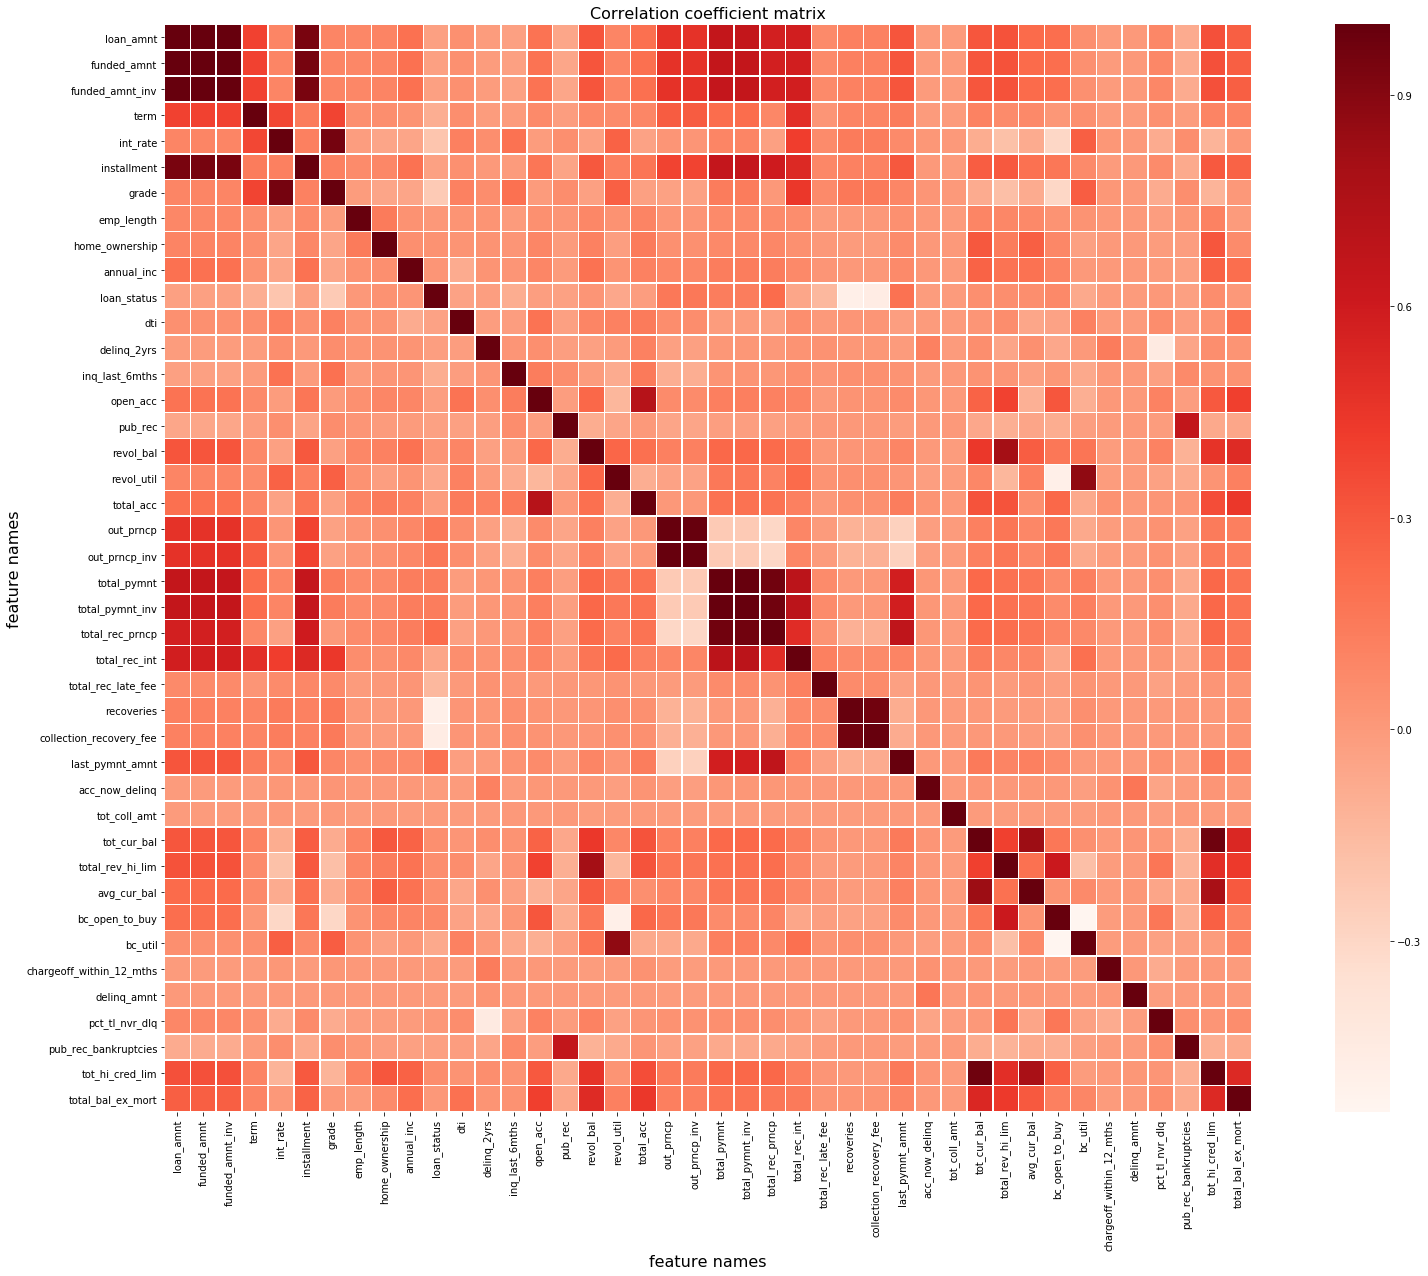

In [19]:
numerical_feature_name = filter_loan_df_6.columns[(filter_loan_df_6.dtypes == "float64") 
                                           | (filter_loan_df_6.dtypes == "int64")].tolist()

# draw pearson correlation coefficient matrix
# if r>0, means positive linear correlation
# if r<0, means negative linear correlation
# if r=0, means no linear correlation
corrmat = filter_loan_df_6[numerical_feature_name].corr()
f, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(corrmat, square=True, ax=ax, cmap="Reds", linewidths=0.5)
ax.set_title("Correlation coefficient matrix", fontsize=16)
ax.set_xlabel("feature names", fontsize=16)
ax.set_ylabel("feature names", fontsize=16)
plt.show()
plt.close()

Here are few features that have a very high corelation amongst each other as follows:  
1) loan_amnt, funded_amnt, funded_amnt_inv, installment  
2) grade, int_rate  
3) out_prncp_inv, out_prncp  
4) total_pymnt, total_ pymnt_inv, total_rec_prncp  
5) collection_recovery_fee, recoveries  
6) tot_hi_cred_lim, tot_cur_bal  

Therefore, let's keep one of each of them and drop other features. 
We can also drop some unnecessary features like 'verification_status', 'issue_d', 'purpose', 'title', 'pymnt_plan', 'debt_settlement_flag', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d'

In [20]:
filter_loan_df_7 = filter_loan_df_6.copy()
filter_loan_df_7 = filter_loan_df_7.drop(['funded_amnt', 'funded_amnt_inv', 'installment', 'int_rate', 
                                          'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 
                                          'collection_recovery_fee', 'tot_hi_cred_lim', 'verification_status', 
                                          'issue_d', 'purpose', 'title', 'pymnt_plan', 'debt_settlement_flag', 
                                          'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'open_acc',
                                          'total_acc','bc_open_to_buy','total_bal_ex_mort','avg_cur_bal',
                                          'tot_cur_bal','revol_util'], 
                                          axis=1, inplace=False)

filter_loan_df_7.head()

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies
0,2500,36.0,3.0,10.0,1.0,55000.0,1.0,18.24,0.0,1.0,...,0.0,84.92,0.0,0.0,42000.0,5.9,0.0,0.0,100.0,1.0
1,30000,60.0,4.0,10.0,2.0,90000.0,1.0,26.52,0.0,0.0,...,0.0,777.23,0.0,1208.0,50800.0,8.3,0.0,0.0,95.0,1.0
2,5000,36.0,4.0,6.0,2.0,59280.0,1.0,10.51,0.0,0.0,...,0.0,180.69,0.0,0.0,24100.0,0.0,0.0,0.0,100.0,0.0
3,4000,36.0,4.0,10.0,2.0,92000.0,1.0,16.74,0.0,0.0,...,0.0,146.51,0.0,686.0,7000.0,75.2,0.0,0.0,100.0,0.0
4,30000,60.0,3.0,10.0,2.0,57250.0,1.0,26.35,0.0,0.0,...,0.0,731.78,0.0,0.0,23100.0,8.9,0.0,0.0,92.3,0.0


### 4) Dataset imputation

In [21]:
#Find the count and percentage of values that are missing in the datafram again
null_loan_df_2 = pd.DataFrame({'Count':filter_loan_df_7.isnull().sum(),
                             'Percent':100*filter_loan_df_7.isnull().sum()/len(filter_loan_df_7)})
#print columns with more than 0 null count
null_loan_df_2[null_loan_df_2['Count']>0]

,Count,Percent
emp_length,540572,23.912047
home_ownership,54,0.002389
annual_inc,4,0.000177
loan_status,2749,0.121601
dti,1711,0.075686
delinq_2yrs,29,0.001283
inq_last_6mths,30,0.001327
pub_rec,29,0.001283
acc_now_delinq,29,0.001283
tot_coll_amt,70276,3.108639


#### a) Mode Imputation
The following features will be mode imputed:  
home_ownership, annual_inc, delinq_2yrs, inq_last_6mths, pub_rec, chargeoff_within_12_mths, delinq_amnt, acc_now_delinq, pub_rec_bankruptcies, dti, emp_length 	

In [22]:
# home_ownership column will be imputed
home_ownership_mode = filter_loan_df_7.copy(deep=True)

home_ownership_mode['home_ownership'].value_counts().head(5)

2.0    1111450
1.0     894929
3.0     253057
4.0        996
6.0        182
Name: home_ownership, dtype: int64

In [23]:
home_ownership_mode['home_ownership'].fillna('2',inplace=True)

#Check the home_ownership Column
home_ownership_mode[home_ownership_mode.home_ownership.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [24]:
# annual_inc column will be imputed
annual_inc_mode = home_ownership_mode.copy(deep=True)

annual_inc_mode['annual_inc'].value_counts().head(5)

60000.0    87189
50000.0    76355
65000.0    64903
70000.0    62078
80000.0    59833
Name: annual_inc, dtype: int64

In [25]:
annual_inc_mode['annual_inc'].fillna('60000.0',inplace=True)

#Check the annual_inc Column
annual_inc_mode[annual_inc_mode.annual_inc.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [26]:
# delinq_2yrs column will be imputed
delinq_2yrs_mode = annual_inc_mode.copy(deep=True)

delinq_2yrs_mode['delinq_2yrs'].value_counts().head(5)

0.0    1839108
1.0     281353
2.0      81289
3.0      29542
4.0      13179
Name: delinq_2yrs, dtype: int64

In [27]:
delinq_2yrs_mode['delinq_2yrs'].fillna('0.0',inplace=True)

#Check the delinq_2yrs Column
delinq_2yrs_mode[delinq_2yrs_mode.delinq_2yrs.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [28]:
# inq_last_6mths column will be imputed
inq_last_6mths_mode = delinq_2yrs_mode.copy(deep=True)

inq_last_6mths_mode['inq_last_6mths'].value_counts().head(5)

0.0    1381722
1.0     584390
2.0     200212
3.0      69009
4.0      17380
Name: inq_last_6mths, dtype: int64

In [29]:
inq_last_6mths_mode['inq_last_6mths'].fillna('0.0',inplace=True)

#Check the inq_last_6mths Column
inq_last_6mths_mode[inq_last_6mths_mode.inq_last_6mths.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [30]:
# pub_rec column will be imputed
pub_rec_mode = inq_last_6mths_mode.copy(deep=True)

pub_rec_mode['pub_rec'].value_counts().head(5)

0.0    1902758
1.0     305390
2.0      34154
3.0      10567
4.0       3872
Name: pub_rec, dtype: int64

In [31]:
pub_rec_mode['pub_rec'].fillna('0.0',inplace=True)

#Check the home_ownership Column
pub_rec_mode[pub_rec_mode.pub_rec.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [32]:
# chargeoff_within_12_mths column will be imputed
chargeoff_within_12_mths_mode = pub_rec_mode.copy(deep=True)

chargeoff_within_12_mths_mode['chargeoff_within_12_mths'].value_counts().head(5)

0.0    2243339
1.0      15765
2.0       1115
3.0        186
4.0         68
Name: chargeoff_within_12_mths, dtype: int64

In [33]:
chargeoff_within_12_mths_mode['chargeoff_within_12_mths'].fillna('0.0',inplace=True)

#Check the chargeoff_within_12_mths Column
chargeoff_within_12_mths_mode[chargeoff_within_12_mths_mode.chargeoff_within_12_mths.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [34]:
# delinq_amnt column will be imputed
delinq_amnt_mode = chargeoff_within_12_mths_mode.copy(deep=True)

delinq_amnt_mode['delinq_amnt'].value_counts().head(5)

0.0        2253465
25.0           124
65000.0        109
30.0            85
53.0            72
Name: delinq_amnt, dtype: int64

In [35]:
delinq_amnt_mode['delinq_amnt'].fillna('0.0',inplace=True)

#Check the delinq_amnt Column
delinq_amnt_mode[delinq_amnt_mode.delinq_amnt.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [36]:
# acc_now_delinq column will be imputed
acc_now_delinq_mode = delinq_amnt_mode.copy(deep=True)

acc_now_delinq_mode['acc_now_delinq'].value_counts().head(5)

0.0    2251857
1.0       8293
2.0        421
3.0         50
4.0         11
Name: acc_now_delinq, dtype: int64

In [37]:
acc_now_delinq_mode['acc_now_delinq'].fillna('0.0',inplace=True)

#Check the acc_now_delinq Column
acc_now_delinq_mode[acc_now_delinq_mode.acc_now_delinq.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [38]:
# pub_rec_bankruptcies column will be imputed
pub_rec_bankruptcies_mode = acc_now_delinq_mode.copy(deep=True)

pub_rec_bankruptcies_mode['pub_rec_bankruptcies'].value_counts().head(5)

0.0    1987383
1.0     258444
2.0      10518
3.0       2131
4.0        541
Name: pub_rec_bankruptcies, dtype: int64

In [39]:
pub_rec_bankruptcies_mode['pub_rec_bankruptcies'].fillna('0.0',inplace=True)

#Check the pub_rec_bankruptcies Column
pub_rec_bankruptcies_mode[pub_rec_bankruptcies_mode.pub_rec_bankruptcies.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [40]:
# dti column will be imputed
dti_mode = pub_rec_bankruptcies_mode.copy(deep=True)

dti_mode['dti'].value_counts().head(5)

0.0     1732
18.0    1584
14.4    1577
16.8    1576
19.2    1566
Name: dti, dtype: int64

In [41]:
dti_mode['dti'].fillna('0.0',inplace=True)

#Check the dti Column
dti_mode[dti_mode.dti.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [42]:
# emp_length column will be imputed
emp_length_mode = dti_mode.copy(deep=True)

emp_length_mode['emp_length'].value_counts().head(5)

10.0    748005
3.0     180753
1.0     148403
5.0     139698
4.0     136605
Name: emp_length, dtype: int64

In [43]:
emp_length_mode['emp_length'].fillna('10.0',inplace=True)

#Check the emp_length_mode Column
emp_length_mode[emp_length_mode.emp_length.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [44]:
#Find the count and percentage of values that are missing in the datafram again
null_loan_df_3 = pd.DataFrame({'Count':emp_length_mode.isnull().sum(),
                             'Percent':100*emp_length_mode.isnull().sum()/len(emp_length_mode)})
#print columns with more than 0 null count
null_loan_df_3[null_loan_df_3['Count']>0]

,Count,Percent
loan_status,2749,0.121601
tot_coll_amt,70276,3.108639
total_rev_hi_lim,70276,3.108639
bc_util,76071,3.364979
pct_tl_nvr_dlq,70431,3.115495


#### b) Mean imputation

In [45]:
# pct_tl_nvr_dlq Column will be imputated
df_avg_pct_tl_nvr_dlq = emp_length_mode.copy(deep=True)

avg_pct_tl_nvr_dlq = df_avg_pct_tl_nvr_dlq['pct_tl_nvr_dlq'].mean()  #Calculate the average age
df_avg_pct_tl_nvr_dlq['pct_tl_nvr_dlq'].fillna(avg_pct_tl_nvr_dlq, inplace = True)

#Check the pct_tl_nvr_dlq Column
df_avg_pct_tl_nvr_dlq[df_avg_pct_tl_nvr_dlq.pct_tl_nvr_dlq.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [46]:
# bc_util Column will be imputated
df_avg_bc_util = df_avg_pct_tl_nvr_dlq.copy(deep=True)

avg_bc_util = df_avg_bc_util['bc_util'].mean()  #Calculate the average bc_util
df_avg_bc_util['bc_util'].fillna(avg_bc_util, inplace = True)

#Check the bc_util Column
df_avg_bc_util[df_avg_bc_util.bc_util.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [47]:
# tot_coll_amt Column will be imputated
df_avg_tot_coll_amt = df_avg_bc_util.copy(deep=True)

avg_tot_coll_amt = df_avg_tot_coll_amt['tot_coll_amt'].mean()  #Calculate the average tot_coll_amt
df_avg_tot_coll_amt['tot_coll_amt'].fillna(avg_tot_coll_amt, inplace = True)

#Check the tot_coll_amt Column
df_avg_tot_coll_amt[df_avg_tot_coll_amt.tot_coll_amt.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [48]:
# total_rev_hi_lim Column will be imputated
df_avg_total_rev_hi_lim = df_avg_tot_coll_amt.copy(deep=True)

avg_total_rev_hi_lim = df_avg_total_rev_hi_lim['total_rev_hi_lim'].mean()  #Calculate the average total_rev_hi_lim
df_avg_total_rev_hi_lim['total_rev_hi_lim'].fillna(avg_total_rev_hi_lim, inplace = True)

#Check the total_rev_hi_lim Column
df_avg_total_rev_hi_lim[df_avg_total_rev_hi_lim.total_rev_hi_lim.isnull()]

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies


In [49]:
#Find the count and percentage of values that are missing in the datafram again
null_loan_df_4 = pd.DataFrame({'Count':df_avg_total_rev_hi_lim.isnull().sum(),
                             'Percent':100*df_avg_total_rev_hi_lim.isnull().sum()/len(df_avg_total_rev_hi_lim)})
#print columns with more than 0 null count
null_loan_df_4[null_loan_df_4['Count']>0]

,Count,Percent
loan_status,2749,0.121601


#### b) k-NN imputation

In [50]:
# define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

# Apply the str_to_cat function
filter_loan_df_cat = str_to_cat(df_avg_total_rev_hi_lim)
filter_loan_df_cat.head()

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,recoveries,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,total_rev_hi_lim,bc_util,chargeoff_within_12_mths,delinq_amnt,pct_tl_nvr_dlq,pub_rec_bankruptcies
0,2500,36.0,3.0,10,1,55000,1.0,18.24,0,1,...,0.0,84.92,0,0.0,42000.0,5.9,0,0,100.0,1
1,30000,60.0,4.0,10,2,90000,1.0,26.52,0,0,...,0.0,777.23,0,1208.0,50800.0,8.3,0,0,95.0,1
2,5000,36.0,4.0,6,2,59280,1.0,10.51,0,0,...,0.0,180.69,0,0.0,24100.0,0.0,0,0,100.0,0
3,4000,36.0,4.0,10,2,92000,1.0,16.74,0,0,...,0.0,146.51,0,686.0,7000.0,75.2,0,0,100.0,0
4,30000,60.0,3.0,10,2,57250,1.0,26.35,0,0,...,0.0,731.78,0,0.0,23100.0,8.9,0,0,92.3,0


In [ ]:
# Use 3 nearest rows which have a feature to fill in each row's missing features
loan_df_filled_knn = KNN(k=3).fit_transform(filter_loan_df_cat)

TypeError: 'Index' object is not callable